### INTERFACE

In [24]:
q = input("Your question: ")

Your question: Who is the CEO for Salesforce?


In [77]:
## Run this to get your answer

get_answer(q)

Analyze question type...
Analyze question keywords...
Pulling all relevant documents...
Filtering most relevant documents...
Extracting all relevant answers...
Narrowing down answers...
-------------------------
Total search time: 1128.0484855175018 seconds
Goetz Vitamin E Shaving
Jack Black Beard Lube Conditioning ShaveAmazon
Jack Black Double-Duty
Jack Black Beard Lube ConditioningAmazon


### ANALYTICS

Text(0.5, 0, '# of docs / keywords')

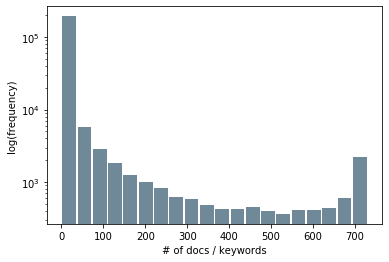

In [47]:
import matplotlib.pyplot as plt

plt.yscale('log',nonposy='clip')
plt.hist(x=dic_size, bins=20, color='#607c8e', alpha=0.9, rwidth=0.9)
plt.ylabel('log(frequency)')
plt.xlabel('# of docs / keywords')

Text(0.5, 0, 'max tf score for each doc')

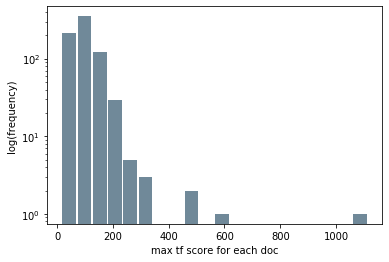

In [55]:
plt.yscale('log',nonposy='clip')
plt.hist(x=max_freq_list, bins=20, color='#607c8e', alpha=0.9, rwidth=0.9)
plt.ylabel('log(frequency)')
plt.xlabel('max tf score for each doc')

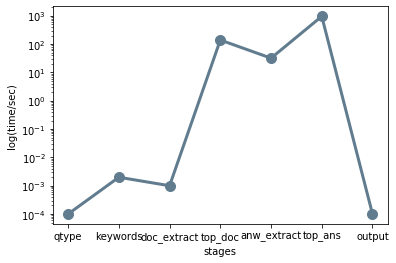

In [75]:
x = ["qtype", "keywords","doc_extract", "top_doc", "anw_extract","top_ans", "output"]

plt.yscale('log',nonposy='clip')
plt.plot(x, time_wise, color='#607c8e', linewidth=3, marker='o',markersize=10)
plt.ylabel('log(time/sec)')
plt.xlabel('stages')
plt.show()


### -------------- internal code -------------------

In [4]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import math
import pandas as pd
import numpy as np
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import time

### SEARCH ENGINE

In [76]:
## Compiling all functions

def get_answer(question):
    
    start = time.time()
    
    ## determine qa type
    print("Analyze question type...")
    qtype = qa_type(question)
    if ("ERROR" in qtype):
        print("Error in determining question type!")
        return
    
    end1 = time.time()
    
    ## question keywords
    keywords = q_keywords(question)
    print("Analyze question keywords...")
    if ("ERROR" in keywords):
        print("Error in determining keyword query!")
        return        
    
    end2 = time.time()
    
    ## doc candidate
    print("Pulling all relevant documents...")
    docandidates = doc_select(keywords)
    if ("ERROR" in docandidates):
        print("Error in selecting relevant documents!")
        return        
    
    end3 = time.time()
    
    ## doc select
    print("Filtering most relevant documents...")
    docanw = doc_top(docandidates, keywords)
    
    end4 = time.time()
    
    ## answer select
    print("Extracting all relevant answers...")
    anscandidate, ansdoc = ans_extract(docanw, qtype)
    if (len(ansdoc) == 0):
        print("Error in getting relevant answers!")
        return
    
    end5 = time.time()
    
    ## top answers
    print("Narrowing down answers...")
    topanswers = ans_score(question, keywords, anscandidate, ansdoc)
    
    end6 = time.time()
    
    
    elapse = str(end6-start)
    ## output
    print("-------------------------")
    print("Total search time: " + elapse + " seconds")
    final = generate_output(topanswers, qtype)
    
    if len(final) < 1:
        print("Entire library searched but no answer found.")
        return
    
    for i in final:
        print(i)

### QA TYPE

In [6]:
## Rule-based, domain-specific method
## CEO / Company / Factor / Percentage

def qa_type(question):
    question = question.replace("?","")
    q_array = question.split()
    q_array = [x.lower() for x in q_array]
        
    if ("ceo" in q_array) or ("who" in q_array):
        return "name"
    elif ("which" in q_array) or ("bankrupt" in q_array) or ("bankruptcy" in q_array):
        return "org"
    elif ("gdp" in q_array) or ("affect" in q_array):
        return "factor"
    elif ("percent" in q_array) or ("percentage" in q_array) or ("drop" in q_array) or ("increase" in q_array):
        return "percent"
    else:
        return "ERROR"

### Q KEYWORDS

In [7]:
## Select keywords from question
## Drop "WH"-based question words, stopwords

def q_keywords(question):
    question = question.replace("?","").lower()
    q_array = word_tokenize(question)
    stop_word = set(stopwords.words("english"))
    q_array = [i for i in q_array if not i in stop_word]
    wh_word = ["what","why","how","who","which"]
    q_array = [i for i in q_array if not i in wh_word]
    
    if len(q_array) < 1:
        return "ERROR"
    
    return q_array

### DOC INDEXING

In [8]:
import glob

fulltext = glob.glob("C:/Users/James Jia/Desktop/HW4/data/*.txt")
with open("C:/Users/James Jia/Desktop/HW4/fulltext.txt","wb") as outfile:
    for f in fulltext:
        with open(f, "rb") as infile:
            content = infile.read()
            outfile.write(content)

In [9]:
text = open("fulltext.txt","r",encoding='utf-8',errors='ignore').read()

In [10]:
text = text.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(","," ").replace(";"," ")
text = text.lower()
text = word_tokenize(text)
stop_word = set(stopwords.words("english"))
text = [i for i in text if not i in stop_word]
lemma = WordNetLemmatizer()
text = [ lemma.lemmatize(token) for token in text ]
text = [ token for token in text if token != '.']

In [11]:
text = list(set(text))

In [56]:
## create document indexing dictionary
index_dict = dict([(t,[]) for t in text ])

In [ ]:
## populate document indexing disctionary
## interate through every document, iter through every keys
## if exist, append to the key's dictionary

doc_id = 0

for i in fulltext:
    
    if (doc_id % 10 == 0):
        print(doc_id)
    
    doc_text = open(i,"r",encoding='utf-8',errors='ignore').read()
    doc_text = doc_text.lower()
    
    for key in text:
        if key in doc_text:
            index_dict[key] = index_dict[key] + [doc_id]
    
    doc_id = doc_id + 1

### DOC SELECTION

In [13]:
## exract a subset of documents at contain at least one keywords

def doc_select(keywords_array):
    result = []
    for i in keywords_array:
        if i in index_dict:
            result = result + index_dict[i]
    result = list(set(result))
    
    if len(result) < 1:
        return "ERROR"
    
    
    return result

### TF-IDF

In [14]:
## compute for each document, the max frequency of any token (non-stop words)
from collections import Counter

doc_id = 0
max_freq_list = []
waste = [",","(",")","``","%",".",";","!","?","''","$","'s","'ve","n't",":","'","’","‘"]

for i in fulltext:
    
    if (doc_id % 70 == 0):
        print(doc_id)
    
    doc_text = open(i,"r",encoding='utf-8',errors='ignore').read()
    doc_text = doc_text.lower()
    doc_text_array = word_tokenize(doc_text)
    doc_text_array = [i for i in doc_text_array if not i in stop_word]
    doc_text_array = [ lemma.lemmatize(token) for token in doc_text_array ]
    doc_text_array = [i for i in doc_text_array if not i in waste]
    
    max_item = Counter(doc_text_array).most_common(1)[0][0]
    max_freq = doc_text_array.count(max_item)
    
    max_freq_list = max_freq_list + [max_freq] 
    
    doc_id = doc_id + 1

0
70
140
210
280
350
420
490
560
630
700


In [15]:
## tf-idf score
## input is keyword query and doc_id

N = len(fulltext)

def tf_idf(keywords, doc):
    doc_text = open(fulltext[doc],"r",encoding='utf-8',errors='ignore').read()
    doc_text = doc_text.lower()
    doc_text_array = word_tokenize(doc_text)
    doc_text_array = [i for i in doc_text_array if not i in stop_word]
    doc_text_array = [ lemma.lemmatize(token) for token in doc_text_array ]
    doc_text_array = [i for i in doc_text_array if not i in waste]
    
    score = 0
    
    for keyword in keywords:
        tf = 0.5 + 0.5*doc_text_array.count(keyword) / max_freq_list[doc]
        if keyword in index_dict:
            dl = len(index_dict[keyword])
            idf = math.log(N / dl)
        else:
            idf = 0
        score = score + tf*idf
    
    return score

In [16]:
## rank the list of doc candidates

def doc_top(doc_list, keywords):
    
    top_doc_num = 5
    score_list = []
    
    for doc in doc_list:
        score_list = score_list + [ tf_idf(keywords, doc) ]
    
    score_list_top_loc = sorted(range(len(score_list)), key=lambda i: score_list[i])[-top_doc_num:]
    score_list_top_loc.reverse()
    top_doc = [doc_list[i] for i in score_list_top_loc]
    
    return top_doc

In [17]:
doc_top([2,0,3,1],["apple","ceo"])

[3, 2, 1, 0]

In [122]:
%store index_dict

Stored 'index_dict' (dict)


In [18]:
%store max_freq_list

Stored 'max_freq_list' (list)


### ANSWER EXTRACTION

In [30]:
## Rule-based
## sentence segmentation
## tag labeling

def ans_extract(doc_list, qtype):
    
    answers = []
    anw_doc = []
    
    for i in doc_list:
        doc_text = open(fulltext[i],"r",encoding='utf-8',errors='ignore').read()
        sentences = sent_tokenize(doc_text)
        
        if qtype == "name": 
            for j in sentences:
                spacy_doc = spacy_nlp(j)
                spacy_ent = [i.label_ for i in spacy_doc.ents]
                if ("ceo" in j.lower()) or ("PERSON" in spacy_ent) or ("ORG" in spacy_ent):
                    answers = answers + [j]
                    anw_doc = anw_doc + [i]
    
        elif qtype == "org":
            for j in sentences:
                spacy_doc = spacy_nlp(j)
                spacy_ent = [i.label_ for i in spacy_doc.ents]
                if ("bankrupt" in j.lower()) or ("bankruptcy" in sentences.lower()) or ("DATE" in spacy_ent) or ("ORG" in spacy_ent):
                    answers = answers + [j]
                    anw_doc = anw_doc + [i]

        elif qtype == "factor":
            for j in sentences:
                spacy_doc = spacy_nlp(j)
                spacy_ent = [i.label_ for i in spacy_doc.ents]
                if ("gdp" in j.lower()) or ("GPE" in spacy_ent) or ("MONEY" in spacy_ent) or ("PERCENT" in spacy_ent):
                    answers = answers + [j]
                    anw_doc = anw_doc + [i]

        elif qtype == "percent":
            for j in sentences:
                spacy_doc = spacy_nlp(j)
                spacy_ent = [i.label_ for i in spacy_doc.ents]
                if ("PERCENT" in spacy_ent):
                    answers = answers + [j]
                    anw_doc = anw_doc + [i]         
    
    return answers, anw_doc

### ANSWER SCORING

In [20]:
## compute 3 factors score and output top answers
## top answers ranked by desc relevance

def ans_score(q, keyword, answers, ans_doc_pair):
    
    top_ans_num = 5
    
    answers_score = []
    q_array = word_tokenize(q.lower())
    q_array = [i for i in q_array if not i in waste]
    q_array_adj = list(zip(q_array, q_array[1:]))
    
    looper = 0
    
    for i in answers:
        a_array = word_tokenize(i.lower())
        a_array = [i for i in a_array if not i in waste]
        a_array_adj = list(zip(a_array, a_array[1:]))
        score_1 = len(list(set(q_array_adj).intersection(a_array_adj)))
        
        doc_id = ans_doc_pair[looper]
        common_token = list(set(q_array).intersection(a_array))
        common_token = [i for i in a_array if not i in stop_word]
        score_2 = tf_idf(common_token, doc_id)
        
        no_mention = [i for i in keyword if not i in a_array]
        score_3 = tf_idf(no_mention, doc_id)
        
        answers_score = answers_score + [score_1 + score_2 - score_3]
        looper = looper + 1
    
    if len(answers_score) > top_ans_num:
        top_ans_loc = sorted(range(len(answers_score)), key=lambda i: answers_score[i])[-top_ans_num:]
        top_ans_loc.reverse()
        top_ans = [answers[i] for i in top_ans_loc]
    else:
        top_ans = answers
        
    return top_ans

In [21]:
ans_score("Who is the CEO of Salesforce?", ["ceo","salesforce"], ["CEO of Salesforce is James Jia", "Nobody know who is leadering Salesforce"],[24,58])

['CEO of Salesforce is James Jia', 'Nobody know who is leadering Salesforce']

### OUTPUT EXTRACTION

In [22]:
## extract the entity from answer sentences

def generate_output(answer_candidates, qtype):
    
    output = []
    
    if qtype == "name": 
        for i in answer_candidates:
            spacy_a = spacy_nlp(i)
            for j in spacy_a.ents:
                if (j.label_ == "PERSON"):
                    output = output + [j.text]

    elif qtype == "org":
        for i in answer_candidates:
            spacy_a = spacy_nlp(i)
            for j in spacy_a.ents:
                if (j.label_ == "ORG"):
                    output = output + [j.text]
                    
    elif qtype == "factor":
        output = answer_candidates


    elif qtype == "percent":
        for i in answer_candidates:
            spacy_a = spacy_nlp(i)
            for j in spacy_a.ents:
                if (j.label_ == "PERCENT"):
                    output = output + [j.text]
                    
    return output


In [23]:
generate_output(["Tim Cook is the company CEO", "Apple's James Jia said he will not quit"], "name")

['Tim Cook', 'James Jia']

In [35]:
## dictionary size

dic_size = []
looper = 0

for i in index_dict:
    
    if (looper % 20000 == 0):
        print(looper)
    looper = looper + 1
    
    dic_size = dic_size + [len(index_dict[i])]



0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000


In [74]:
time_wise = [0.0001,
             0.0019893646240234375,
             0.0009975433349609375,
             139.70322370529175,
             32.001895904541016,
             959.1982972621918,
             0.0001]